In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
import cv2
import pandas as pd
import numpy as np
import random

from torch import Tensor
from torch.nn import Module, CosineSimilarity
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as tf
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [17]:
def set_seeds(seed: int = 42):
    """
    Sets random seed for reproducibility.
    :param seed: (int, optional): Random seed. Defaults to 42
    :return: 
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [18]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")    

Using device: cpu


# Create Celebs Dataset

In [6]:
from dataset.celeb import CelebDataset

In [7]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

# Example of faces in dataset

In [5]:
def draw_samples(dataset: Dataset):
    nrows, ncols = 1,  10
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
    ax = ax.flatten()
    to_pil = tf.ToPILImage()
    for i in range(nrows * ncols):
        rand_index = random.randint(0, len(dataset) - 1)
        image_tensor = dataset[rand_index][0]
        pil_image = to_pil(image_tensor)
        ax[i].imshow(pil_image)

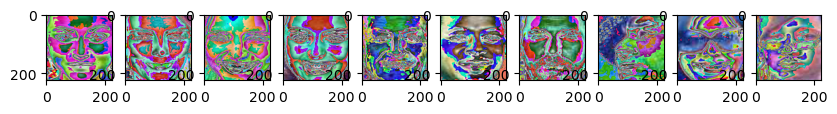

In [6]:
draw_samples(train_dataset)

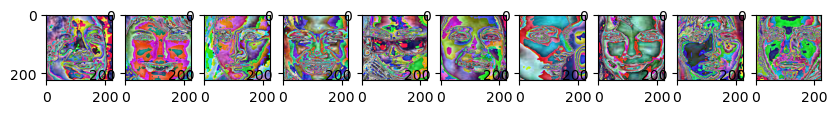

In [7]:
draw_samples(val_dataset)

## Weighted Random Sampler для учета дисбаланса классов

In [8]:
from collections  import Counter
from torch.utils.data.sampler import WeightedRandomSampler

train_targets = train_dataset.train_images['Target']
targets_count = Counter(i for i in train_targets)
weights = [1/targets_count.get(i) for i in train_targets]

weighted_random_sampler = WeightedRandomSampler(weights, num_samples=len(weights))

len(weights), weighted_random_sampler

(8318, <torch.utils.data.sampler.WeightedRandomSampler at 0x7fba654bfa00>)


# ResNet + Cross-Entropy Loss

Let's use pretrained ResNet network. Here I change fully-connected layers and freeze convolutional layers to relearn the network to recognize faces. 

In [12]:
from network.network import ResNet18WithClassifier

model: ResNet18WithClassifier = ResNet18WithClassifier(num_classes=train_dataset.class_count())


In [13]:
for param in model.resnet.parameters():
    param.requires_grad = True

for param in model.resnet.layer1.parameters():
    param.requires_grad = True

for param in model.resnet.layer2.parameters():
    param.requires_grad = True

for param in model.resnet.layer3.parameters():
    param.requires_grad = True

for param in model.resnet.layer4.parameters():
    param.requires_grad = True

for param in model.resnet.fc.parameters():
    param.requires_grad = True

In [14]:
# Let's look at network architecture
from torchinfo import summary
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
ResNet18WithClassifier                        [32, 3, 224, 224]    [32, 464]            --                   True
├─ResNet: 1-1                                 [32, 3, 224, 224]    [32, 464]            --                   True
│    └─Conv2d: 2-1                            [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU: 2-3                              [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d: 2-4                         [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential: 2-5                        [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]     [32, 64, 56, 56]    

## Loss Function and Optimizer

In [15]:
epochs = 100
lr = 1e-3
batch_size = 256

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=weighted_random_sampler
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

## Run Train Loop

In [16]:
from train.train import train

set_seeds()

history = train(
    epochs=epochs,
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

NameError: name 'set_seeds' is not defined

# ResNet + ArcFace + Cross-Entropy Loss

In [8]:
from network.network import ResNet18WithArcFace

arc_face_model: ResNet18WithArcFace = ResNet18WithArcFace(device, train_dataset.class_count())

In [10]:
arc_face_model

ResNet18WithArcFace(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [9]:
for param in arc_face_model.backbone.parameters():
    param.requires_grad = True

for param in arc_face_model.backbone.layer1.parameters():
    param.requires_grad = True

for param in arc_face_model.backbone.layer2.parameters():
    param.requires_grad = True

for param in arc_face_model.backbone.layer3.parameters():
    param.requires_grad = True

for param in arc_face_model.backbone.layer4.parameters():
    param.requires_grad = True

for param in arc_face_model.backbone.fc.parameters():
    param.requires_grad = True

In [ ]:
arc_face_epochs = 100

arc_face_lr = 1e-3
arc_face_gamma = 0.3
arc_face_step_size = 5

arc_face_batch_size = 256

arc_face_optimizer = optim.Adam(arc_face_model.parameters(), lr=arc_face_lr)
arc_face_scheduler = None

arc_face_criterion = torch.nn.CrossEntropyLoss()

arc_face_train_dataloader = DataLoader(dataset=train_dataset, batch_size=arc_face_batch_size, sampler=weighted_random_sampler)
arc_face_val_dataloader = DataLoader(dataset=val_dataset, batch_size=arc_face_batch_size)
arc_face_test_dataloader = DataLoader(dataset=test_dataset, batch_size=arc_face_batch_size)

In [ ]:
history = train(
    epochs=arc_face_epochs,
    model=arc_face_model,
    train_dataloader=arc_face_train_dataloader,
    val_dataloader=arc_face_val_dataloader,
    criterion=arc_face_criterion,
    optimizer=arc_face_optimizer,
    learning_rate_scheduler=arc_face_scheduler,
    device=device
)